In [1]:
import pandas as pd
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from Clean import Clean

%matplotlib inline

# Data Prep

In [2]:
df = pd.read_csv('FM_2000-2019.csv')
print(df.shape)
df_all = df[df['gp_all_0_a'] >= 30]
df = df_all[0:-100]
df_test = df_all[-100:]
print(df.shape)

(24171, 459)
(14392, 459)


In [3]:
games = 30
q = 1

clean = Clean(df,games)
features = clean.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y = clean.get_target(q).values

In [4]:
cols = features.columns
print(cols)
x = features.values
print(x)
print(x.shape)
print(y)
print(y.shape)

Index(['e-off-rating_all_0_a', 'e-def-rating_all_0_a', 'e-pace_all_0_a',
       'e-off-rating_court_0_a', 'e-def-rating_court_0_a', 'e-pace_court_0_a',
       'e-off-rating_all_1_a', 'e-def-rating_all_1_a', 'e-pace_all_1_a',
       'e-off-rating_court_1_a', 'e-def-rating_court_1_a', 'e-pace_court_1_a',
       'e-off-rating_all_0_h', 'e-def-rating_all_0_h', 'e-pace_all_0_h',
       'e-off-rating_court_0_h', 'e-def-rating_court_0_h', 'e-pace_court_0_h',
       'e-off-rating_all_1_h', 'e-def-rating_all_1_h', 'e-pace_all_1_h',
       'e-off-rating_court_1_h', 'e-def-rating_court_1_h', 'e-pace_court_1_h'],
      dtype='object')
[[105.6 100.8  97.4 ... 106.4 106.6 102. ]
 [102.4 109.2 104.  ... 108.1 103.4  96.8]
 [107.9 107.9 102.1 ... 111.6 105.2  99.7]
 ...
 [104.2 109.1  96.7 ... 106.4  99.9 103.2]
 [104.7 108.7  99.  ... 105.5 106.1  99.3]
 [109.4 100.9  96.7 ... 105.1  98.7 102.5]]
(14195, 24)
[59 47 55 ... 51 62 41]
(14195,)


# Fit a basic linear model

In [5]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=x.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(x,beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=y)

In [8]:
with basic_model:
    step = pm.NUTS()
    trace = pm.sample(cores=2)
    # trace = pm.sample(cores=4, target_accept=0.95)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [07:50<00:00,  4.25draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6257048097731541, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Anaconda\envs\bml-nba\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D8E9A1EC08>,
      dtype=object)

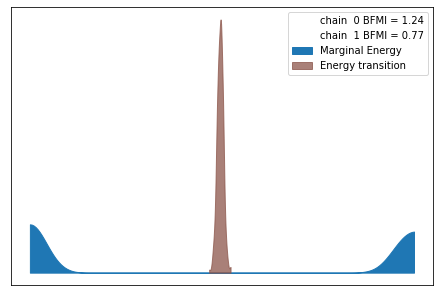

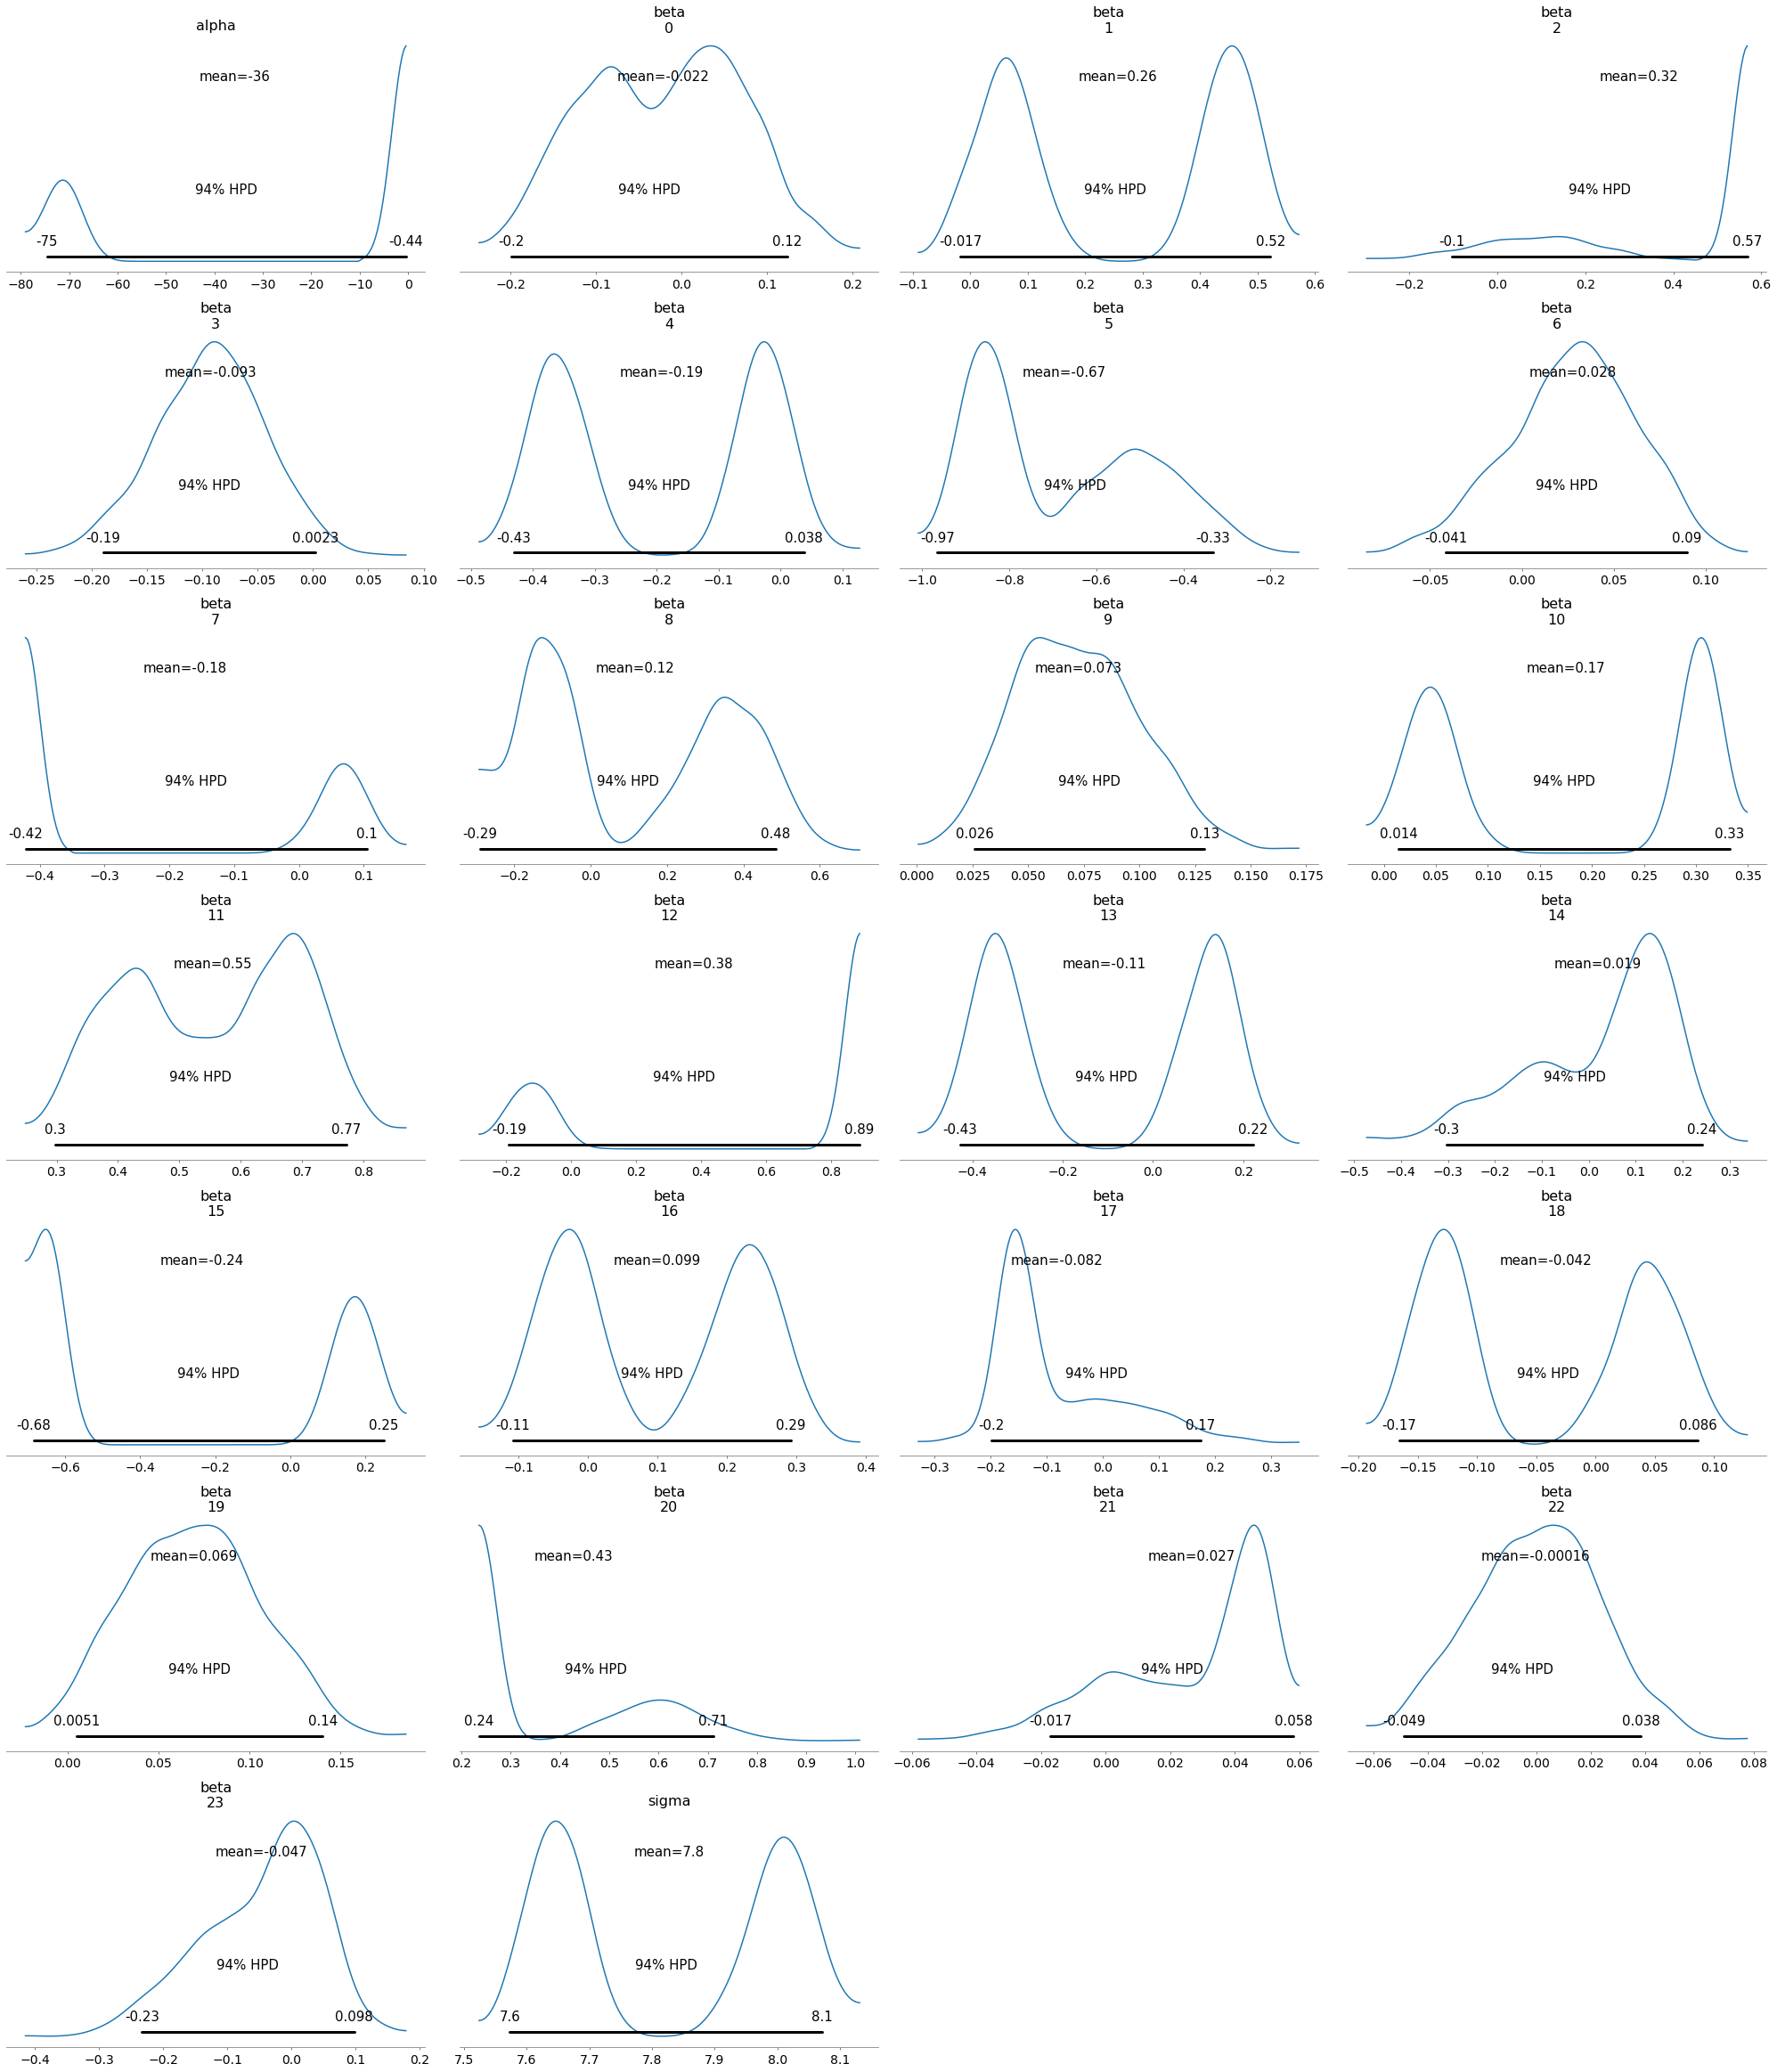

In [9]:
pm.summary(trace).round(2)
pm.energyplot(trace)
pm.plot_posterior(trace)

# Posterior Predictive Checks 

In [10]:
with basic_model:
    ppc = pm.sample_posterior_predictive(trace, samples=500)


100%|██████████| 500/500 [00:00<00:00, 568.11it/s]


In [22]:
ppc['Y_obs']

array([[353.45662472, 314.99811265, 331.39665521, ..., 333.52773125,
        338.10154639, 347.91371539],
       [351.69129865, 315.21817508, 330.39388898, ..., 334.44693482,
        339.0951589 , 348.78530767],
       [354.73168406, 309.37083379, 332.70713478, ..., 336.81383848,
        339.72515391, 348.26375516],
       ...,
       [358.27153853, 326.45199987, 316.30891193, ..., 347.36318149,
        338.25959148, 330.51089993],
       [352.90692694, 296.70184438, 337.87609444, ..., 334.69947547,
        339.02703422, 349.95969195],
       [354.50461854, 337.1327707 , 325.52648078, ..., 313.90715989,
        347.35962328, 356.85348235]])

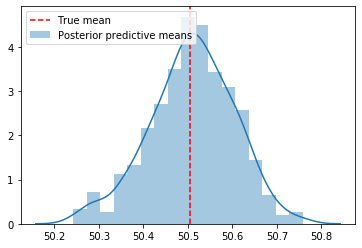

In [11]:
fig, ax = plt.subplots()
sns.distplot(ppc['obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(y.mean(), ls='--', color='r', label='True mean')
ax.legend(); 